# End-to-End modeling workflow with SAP

Author: Dennis Whitney

Version Date: 27/April/2023

[Reference DataRobot's API documentation](https://docs.datarobot.com/en/docs/api/reference/index.html)

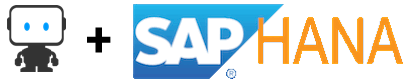

# Overview

This notebook demonstrates an end-to-end workflow using DataRobot with SAP as the remote data source.

The data set used for this notebook is the [Auto MPG eample in the Quickstart example](https://docs.datarobot.com/en/docs/api/api-quickstart/index.html) and an example method for loading this data into the SAP Hana database is given in the [Sample SAP HANA data load appendix](#appendix-sample-sap-hana-data-load) at the end of this document.

The workflow consists of the following steps:

- Use the SAP HANA JDBC driver
- [Create DataRobot credentials](https://docs.datarobot.com/en/docs/data/connect-data/stored-creds.html#stored-data-credentials)
- Read a SAP HANA schema.table into DataRobot's AI Catalog
- Start a project with the dataset
- Deploy the recomended model
- Score via batch and real-time prediction requests
- Clean up the created artifacts

### Reference documentation

- [DataRobot Python API documentation](https://datarobot-public-api-client.readthedocs-hosted.com/en/latest-release/)
- [DataRobot API quickstart guide](https://docs.datarobot.com/en/docs/api/api-quickstart/index.html)

### Prerequisites

- If your DataRobot version is <= 9.0, use Python SDK version 2.28.1
- If your DataRobot version is later than 9.0, use Python SDK version 3.0 or later
- You must provide a [DataRobot API key](https://docs.datarobot.com/en/docs/platform/account-mgmt/acct-settings/api-key-mgmt.html#api-key-management) for the DataRobot cluster in use
- [The SAP HANA JDBC Driver must be installed](https://repo1.maven.org/maven2/com/sap/cloud/db/jdbc/ngdbc/2.16.11/)
- Use a working SAP HANA installation
  - [This example uses Red Hat Enterprise Linux 9.0](https://cloud.redhat.com/blog/containerizing-sap-hana-express-on-red-hat-enterprise-linux)
- [Valid DataRobot credentials for the data source](https://docs.datarobot.com/en/docs/data/connect-data/stored-creds.html#stored-data-credentials) 
- Networking must allow for port 22 for SSH and 39041 for the SAP HANA server

# Notes

Below are the assorted notes found while using this notebook that may be useful

**Note 1:** The jdbc connector, credentials and the data connection do not allow for finding with an id, so this notebook will use the name instead.

**Note 2:** A future release of this notebook will demonstrate prediction write back.

# Install Libraries

If you are using VS Code, you can install the required DataRobot packages with the cell below. Otherwise, use the cell that follows it.

In [ ]:
!{sys.executable} -m pip install --upgrade pip

# Use when using DatgaRobot 8.x
!{sys.executable} -m pip install "datarobot>=2.28,<2.29"

## Use for DataRobot 9.x or app.datarobot.com
# !{sys.executable} -m pip install datarobot

In [ ]:
!pip3 install --upgrade pip

# Use when using DatgaRobot 8.x
!pip3 install "datarobot>=2.28,<2.29"

## Use for DataRobot 9.x or app.datarobot.com
# !pip3 install datarobot

# Import libraries and set parameters

The following code block will import the required python packages and provides a single place to set the parameters required to make the notebook work properly.

**Please note:** These parameters are aligned to use the [Sample SAP HANA data load appendix](#appendix-sample-sap-hana-data-load) at the end of this document and you will need to update to suit your needs.

In [ ]:
import datarobot as dr
from datarobot.models import Deployment, ServiceStats
from datarobot.enums import SERVICE_STAT_METRIC
from datarobot import AUTOPILOT_MODE
import json
from urllib.parse import urlparse
import csv
import requests
import pprint

# Provide the URL protocol, address (IP or FQDN)
# Example: https://datarobot.example.com or http://10.1.2.3
DATAROBOT_ENDPOINT = '<Your DataRobot endpoint goes here>'

# Provide an API key from a user with permission from this cluster
DATAROBOT_API_TOKEN = '<A valid DataRobot API key goes here>'

# Define the SAP Hana deployment
# The settings below assumes the usage of the example data load defined at the end of this AI Accelerator
# If you are using a custom database, you must update as required
SAP_JDBC_URL = 'jdbc:sap://<the SAP Hana IP goes here>:39041?databaseName=HXE'

### JDBC Connectivity settings
JDBC_USERNAME = 'JDBC_DR_WORKER'
JDBC_PASSWORD = 'His_Password_1'

### JDBC Driver Settings
JDBC_CREDENTIAL_NAME = 'SAP_HANA_CREDENTIAL'
SAP_JDBC_DRIVER_NAME = '2.16.11'
SAP_DATASTORE_NAME = 'SAP_HANA_DataStore'

### SQL Data Extraction statements
TRAIN_DATASOURCE_NAME = "SAP_HANA_DataSource"
TRAIN_EXTRACTION_SQL = 'SELECT MPG,CYLINDERS,DISPLACEMENT,HORSEPOWER,WEIGHT,ACCELERATION,MODELYEAR,ORIGIN FROM DATAINPUT.AUTOMPG;'
PREDICT_DATASOURCE_NAME = "SAP_HANA_DataSource4Prediction"
PREDICT_EXTRACTION_SQL = 'SELECT MPG,CYLINDERS,DISPLACEMENT,HORSEPOWER,WEIGHT,ACCELERATION,MODELYEAR,ORIGIN FROM DATAINPUT.AUTOMPG LIMIT 10;'

### DataRobot project settings
PROJECT_NAME = 'AutomobileMpG'
PROJECT_WORKERS = -1
TARGET = 'MPG'
METRIC = 'RMSE'

# Turn on DEBUG statements
DEBUG = False # True # 

# Set Autopilot mode
OMODE = AUTOPILOT_MODE.QUICK

# These values are mostly constant
# Create the shared DataRobot client
my_client = dr.Client(
    token = '%s' % (DATAROBOT_API_TOKEN),
    endpoint = '%s/api/v2' % (DATAROBOT_ENDPOINT),
    ssl_verify = True if (urlparse(DATAROBOT_ENDPOINT)).scheme == 'https' else False,
    user_agent_suffix = 'AIA-E2E-SAPWORKFLOW-125' # Optional. Helps DataRobot improve this workflow
)

# Find the dedicated prediction engine URL
PREDICTION_SERVER = dr.PredictionServer.list()[0]

# Verbose settings statement
print("# -----------------------------------------")
print("DataRobot client version: %s" % dr.__version__)
print("# -----------------------------------------")
print("DATAROBOT_ENDPOINT: %s | %s" % (DATAROBOT_ENDPOINT, PREDICTION_SERVER))
print("DATAROBOT_API_TOKEN: %s" % (DATAROBOT_API_TOKEN))
print("# Credentials settings -------------------")
print("JDBC_CREDENTIAL_NAME: %s" % (JDBC_CREDENTIAL_NAME))
print("JDBC_USERNAME: %s" % (JDBC_USERNAME))
print("JDBC_PASSWORD: %s" % (JDBC_PASSWORD))
print("# DataStore settings ---------------------")
print("SAP_JDBC_DRIVER_NAME: %s" % (SAP_JDBC_DRIVER_NAME))
print("SAP_DATASTORE_NAME: %s" % (SAP_DATASTORE_NAME))
print("SAP_JDBC_URL: %s" % (SAP_JDBC_URL))
print("TRAIN_DATASOURCE_NAME: %s" % (TRAIN_DATASOURCE_NAME))
print("TRAIN_EXTRACTION_SQL: %s" % (TRAIN_EXTRACTION_SQL))
print("PREDICT_DATASOURCE_NAME: %s" % (PREDICT_DATASOURCE_NAME))
print("PREDICT_EXTRACTION_SQL: %s" % (PREDICT_EXTRACTION_SQL))
print("# Project settings ------------------------")
print("PROJECT_NAME: %s" % (PROJECT_NAME))
print("TARGET: %s | METRIC: %s" % (TARGET, METRIC))

# Create the Basic Credentials

The API will now build a Credentials set that will be used for Authentication when data is extracted, using the JDBC username and password

For more information on credentials, reference the [Python SDK documentation](https://datarobot-public-api-client.readthedocs-hosted.com/en/latest-release/reference/admin/credentials.html?highlight=Credential#basic-credentials).

**Please Note:** This notebook shares a set of credentials across the train and predict data sources.

In [ ]:
CREDENTIAL = dr.Credential.create_basic(
    name=JDBC_CREDENTIAL_NAME,
    user=JDBC_USERNAME,
    password=JDBC_PASSWORD,
)

print("Created CREDENTIAL: %s" % (CREDENTIAL))

# Create a DataStore

The API code block below will find the existing SAP Hana JDBC driver ([See the Prerequisites above](#prerequisites)) and build a DataStore (or Data Connection) based on it, passing the jdbc url used to conenct to the source.

For more information on data connections, reference the [Python SDK documentation](https://datarobot-public-api-client.readthedocs-hosted.com/en/latest-release/reference/data/database_connectivity.html#creating-datastores).

To find a suitable JDBC driver, please refer to the [SAP Hana Maven repo](https://mvnrepository.com/artifact/com.sap.cloud.db.jdbc/ngdbc)

In [ ]:
# Set the driver name in the SAP Hana JDBC driver name temaplate
jdbc_driver_name = "SAP HANA (%s)" % SAP_JDBC_DRIVER_NAME

JDBC_DRIVER = [drs for drs in dr.DataDriver.list() if drs.canonical_name == jdbc_driver_name][-1]
print("Using JDBC_DRIVER: %s" % (JDBC_DRIVER))

DATASTORE = dr.DataStore.create(
    data_store_type='jdbc',
    canonical_name=SAP_DATASTORE_NAME,
    driver_id=JDBC_DRIVER.id,
    jdbc_url=SAP_JDBC_URL
)
print("Created DATASTORE: %s" % (DATASTORE))

# Create the DataSources

This section of the notebook will create the Training and Prediction DataSources used in the AI Catalog.

**Please Note:** The Training DataSource is used during the Model Creation and Training phase and the Prediction DataSource is used to make predictions.

For more information on data sources, reference the [Python SDK documentation](https://datarobot-public-api-client.readthedocs-hosted.com/en/latest-release/reference/data/database_connectivity.html#creating-datasources).

In [ ]:
TRAIN_DATASOURCE = dr.DataSource.create(
    data_source_type = 'jdbc',
    canonical_name = TRAIN_DATASOURCE_NAME,
    params = dr.DataSourceParameters(
        data_store_id=DATASTORE.id,
        query=TRAIN_EXTRACTION_SQL,
    )
)
print("Created TRAIN_DATASOURCE id: %s | %s" % (TRAIN_DATASOURCE.id, TRAIN_DATASOURCE))

PREDICT_DATASOURCE = dr.DataSource.create(
    data_source_type = 'jdbc',
    canonical_name = PREDICT_DATASOURCE_NAME,
    params = dr.DataSourceParameters(
        data_store_id=DATASTORE.id,
        query=PREDICT_EXTRACTION_SQL,
    )
)
print("Created PREDICT_DATASOURCE id: %s | %s" % (PREDICT_DATASOURCE.id, PREDICT_DATASOURCE))

# Create the Datasets

This is where the notebook will push the 2 DataSources to the AI Catalog as a DataSet, with:
1. The Train Extraction SQL statement
2. The Prediction Extraction SQL statement

For more information on creating a dataset, reference the [Python SDK referenece documentation](https://datarobot-public-api-client.readthedocs-hosted.com/en/latest-release/autodoc/api_reference.html?highlight=create_dataset#datarobot.DataSource.create_dataset) and [its user guide](https://datarobot-public-api-client.readthedocs-hosted.com/en/latest-release/reference/data/dataset.html?highlight=find%20dataset). 

In [ ]:
# Create for the Training DataSet
TRAIN_DATASET = TRAIN_DATASOURCE.create_dataset(do_snapshot=False, credential_id=CREDENTIAL.credential_id)
print("Created TRAIN_DATASET id: %s | %s" % (TRAIN_DATASET.id, TRAIN_DATASET))

# Create for the Prediction Source
# Please note the "do_snapshot=True" which is required for prediction datasets
PREDICT_DATASET = PREDICT_DATASOURCE.create_dataset(do_snapshot=True, credential_id=CREDENTIAL.credential_id)
print("Created PREDICT_DATASET id: %s | %s" % (PREDICT_DATASET.id, PREDICT_DATASET))

# Handy debug statement to open a browser tab pointing to the Training DataSet in the AI Catalog
if str(dr.__version__) > str(3) and DEBUG:
    TRAIN_DATASET.open_in_browser()

# Create a project

The notebook will now create a Project based off the Training DataSet in the AI Catalog. This is where the API sets the name, credentails to use, the target and the other required parameters.

The code set below will show the existing worker and job state to show the current usage, the Project status as it processes the models and data and finally the exit worker state.

For more information on DataRobot Projects, please [Reference documentation for the Python SDK](https://datarobot-public-api-client.readthedocs-hosted.com/en/latest-release/reference/modeling/project.html)

In [ ]:
# Find the current worker and job status, which is a good measure of system usage
WORKERS_BEFORE = (json.loads( my_client.get('resourceMonitor').text ))['workers']
print("workers before: %s | inUse: %s | usersRunning: %s | jobsWaiting: %s | usersWaiting: %s" % (WORKERS_BEFORE['total'], WORKERS_BEFORE['inUse'], WORKERS_BEFORE['usersRunning'], WORKERS_BEFORE['jobsWaiting'], WORKERS_BEFORE['usersWaiting']) )

PROJECT = TRAIN_DATASET.create_project(project_name=PROJECT_NAME, credential_id=CREDENTIAL.credential_id)
print("Created PROJECT: %s" % (PROJECT))

PROJECT.set_target(target=TARGET, metric=METRIC, mode=OMODE, worker_count=PROJECT_WORKERS)
PROJECT.wait_for_autopilot()

print("PROJECT %s info: %s" % (PROJECT.id, PROJECT))

# An easy way to confirm the worker autoscaling is working as expected
WORKERS_AFTER = (json.loads( my_client.get('resourceMonitor').text ))['workers']
print("workers after: %s | inUse: %s | usersRunning: %s | jobsWaiting: %s | usersWaiting: %s" % (WORKERS_AFTER['total'], WORKERS_AFTER['inUse'], WORKERS_AFTER['usersRunning'], WORKERS_AFTER['jobsWaiting'], WORKERS_AFTER['usersWaiting']) )

if str(dr.__version__) > str(3) and DEBUG:
    PROJECT.open_in_browser()

# Get the model recomended for deployment

The code set below will get what DataRobot has determined to be the recomended model for deployment and display the models validation and crossValidation metrics.

[Reference documentation for model recommendation](https://datarobot-public-api-client.readthedocs-hosted.com/en/latest-release/reference/modeling/model_recommendation.html?highlight=dr.ModelRecommendation.get#get-recommended-model)

In [ ]:
TOP_MODEL = dr.ModelRecommendation.get( PROJECT.id, dr.enums.RECOMMENDED_MODEL_TYPE.RECOMMENDED_FOR_DEPLOYMENT ).get_model()

print("Using Recommended Model id: %s | %s" % (TOP_MODEL.id, TOP_MODEL))
print("validation: %s | crossValidation: %s" % ( TOP_MODEL.metrics[PROJECT.metric]['validation'], TOP_MODEL.metrics[PROJECT.metric]['crossValidation']))

if str(dr.__version__) > str(3) and DEBUG:
    TOP_MODEL.open_model_browser()

# Deploy the top model

This code block will push the given model out to the DataRobot Prediction Server such that it can now serve requests with predictions. For more information, please [Reference the documentation for deployments](https://datarobot-public-api-client.readthedocs-hosted.com/en/v3.0.2/reference/mlops/deployment.html#create-a-deployment)

In [ ]:
DEPLOYMENT = dr.Deployment.create_from_learning_model(
    TOP_MODEL.id,
    label='%s RECOMMENDED_MODEL' % PROJECT.project_name,
    description='API %s deployment of: %s' % (PROJECT.project_name, TOP_MODEL.model_type),
    default_prediction_server_id=PREDICTION_SERVER.id
)

if str(dr.__version__) > str(3) and DEBUG:
    DEPLOYMENT.open_in_browser()

print("Created DEPLOYMENT: %s | %s" % (DEPLOYMENT.id, DEPLOYMENT))

# Predictions

Now that the heavy lifting of Training and Deploying the model is complete, we can start making predictions with that model via the Dedicated Prediction Server.

This note book will demonstate the 2 types of Predictions: Batch and Real-Time

## Make Batch Predictions with SQL Statement

This example shows how to pull data via a fresh JDBC select statement and saves the results to a local file.

[Reference documentation for batch predictions](https://datarobot-public-api-client.readthedocs-hosted.com/en/v2.28.1/reference/predictions/batch_predictions.html)

In [ ]:
JDBC_BATCH_PREDICTION_JOB = dr.BatchPredictionJob.score(
    deployment=DEPLOYMENT.id,
    passthrough_columns = ['MPG','CYLINDERS','DISPLACEMENT','HORSEPOWER','WEIGHT','ACCELERATION','MODELYEAR','ORIGIN'],
    intake_settings = {
        'type': 'jdbc',
        'query': PREDICT_EXTRACTION_SQL, #   "select * from new_york_taxi.input limit 1000",
        'data_store_id': DATASTORE.id, # The ID of the data store you want
        'credential_id': CREDENTIAL.credential_id # The credentialid of the credentials stored in your credentials manager
    },
    output_settings={ 'type': 'localFile', 'path': "jdbc-batch-predictions.csv", },
)

JDBC_BATCH_PREDICTION_JOB.wait_for_completion()

with open('jdbc-batch-predictions.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    for line in csv_reader:
        print(line)

## Batch Predictions using the AI Catalog

The following cell reads from the latest version of the PREDICT_DATASOURCE_NAME in the AI Catalog and outputs to a local file. 

**Please Note:** Becuase this method uses an AI Catalog entry to score, it is expected to be faster than the method above that makes a fresh resqust to the SAP Hana database.

For further information, please see the [Reference documentation](https://datarobot-public-api-client.readthedocs-hosted.com/en/v2.28.1/reference/predictions/batch_predictions.html#local-file-output)

In [ ]:
AICATALOG_BATCH_PREDICTION_JOB = dr.BatchPredictionJob.score(
    deployment=DEPLOYMENT.id,
    passthrough_columns = ['MPG','CYLINDERS','DISPLACEMENT','HORSEPOWER','WEIGHT','ACCELERATION','MODELYEAR','ORIGIN'],
    intake_settings={
        'type': 'dataset',
        'dataset': PREDICT_DATASET,
        'dataset_version_id': PREDICT_DATASET.version_id
    },
    output_settings={ 'type': 'localFile', 'path': "aicatalog-batch-predictions.csv" },
)
AICATALOG_BATCH_PREDICTION_JOB.wait_for_completion()
AICATALOG_BATCH_PREDICTION_JOB.get_status()

with open('aicatalog-batch-predictions.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    for line in csv_reader:
        print(line)

# Make Batch Predictions

This section will read from the latest version in the AI Catalog and outputs to the SAP Hana database using the JDBC connector

**Please Note:** this is a work in progress and will be ready soon after this page says its available: [Data sources supported for batch predictions](https://docs.datarobot.com/en/docs/api/reference/batch-prediction-api/index.html#data-sources-supported-for-batch-predictions)

For further information, please see the [Reference documentation](https://datarobot-public-api-client.readthedocs-hosted.com/en/v2.28.1/reference/predictions/batch_predictions.html#jdbc-output)

In [ ]:
### WIP
# AICATALOG_BATCH_PREDICTION_JOB_WITH_WRITEBACK = dr.BatchPredictionJob.score(
#     deployment=DEPLOYMENT.id,
#     passthrough_columns = ['MPG','CYLINDERS','DISPLACEMENT','HORSEPOWER','WEIGHT','ACCELERATION','MODELYEAR','ORIGIN'],
#     intake_settings={
#         'type': 'dataset',
#         'dataset': PREDICT_DATASET,
#         'dataset_version_id': PREDICT_DATASET.version_id
#     },
#     output_settings = {
#         'type': 'jdbc',
#         'table': 'scoring_data',
#         'statement_type': 'insert',
#         'data_store_id': DATASTORE.id,
#         'credential_id': CREDENTIAL.credential_id,
#         'create_table_if_not_exists': True
#     },
# )
# AICATALOG_BATCH_PREDICTION_JOB_WITH_WRITEBACK.wait_for_completion()
# AICATALOG_BATCH_PREDICTION_JOB_WITH_WRITEBACK.get_status()

# Make real-time predictions

The notebook will now make a small set of real time predictions where speed is king

[Reference documentation](https://docs.datarobot.com/en/docs/api/reference/predapi/dr-predapi.html#datarobot-prediction-api)

In [ ]:
# JSON records for example automobiles for which to predict mpg
autos = [
    { "CYLINDERS": 4, "DISPLACEMENT": 119.0, "HORSEPOWER": 82.00, "WEIGHT": 2720.0, "ACCELERATION": 19.4, "MODELYEAR": 82, "ORIGIN": 1, },     
    { "CYLINDERS": 8, "DISPLACEMENT": 120.0, "HORSEPOWER": 79.00, "WEIGHT": 2625.0, "ACCELERATION": 18.6, "MODELYEAR": 82, "ORIGIN": 1, },
]

# Create REST request for prediction API
prediction_server = DEPLOYMENT.default_prediction_server

print("prediction_server: %s" % prediction_server)

prediction_headers = {
    "Authorization": "Bearer {}".format(DATAROBOT_API_TOKEN),
    'User-Agent': 'AIA-E2E-SAPWORKFLOW-125', # Optional but helps DataRobot improve this workflow
    "Content-Type": "application/json"
}

REALTINE_PREDICTIONS = requests.post(
    "%s/predApi/v1.0/deployments/%s/predictions?passthroughColumns=CYLINDERS&passthroughColumns=DISPLACEMENT&passthroughColumns=HORSEPOWER&passthroughColumns=WEIGHT&passthroughColumns=ACCELERATION&passthroughColumns=MODELYEAR&passthroughColumns=ORIGIN" % (prediction_server['url'], DEPLOYMENT.id ),
    data=json.dumps(autos),
    headers=prediction_headers    
)

pprint.pprint(REALTINE_PREDICTIONS.json())

# Show Deployment Prediction Information

[Reference documentation for service stats](https://datarobot-public-api-client.readthedocs-hosted.com/en/v3.0.2/reference/mlops/deployment.html#service-stats)

In [ ]:
service_stats = ServiceStats.get(DEPLOYMENT.id)

print("service_stats: %s" % (service_stats))
print("TOTAL_PREDICTIONS: %s" % (service_stats[SERVICE_STAT_METRIC.TOTAL_PREDICTIONS]))

## Cleanup

This section below will remove everything that was created above.

In [ ]:
items_deleted = 0

# Delete the deployment
DEPLOYMENT.delete()
print("Deleted DEPLOYMENT id: %s | %s" % ( DEPLOYMENT.id, DEPLOYMENT ))
items_deleted += 1

# Delete the Project
PROJECT.delete()
print("Deleted PROJECT id: %s | %s" % ( PROJECT.id, PROJECT ))
items_deleted += 1

# Delete the training dataset
dr.Dataset.delete(TRAIN_DATASET.id)
print("Deleted TRAIN_DATASET id: %s | %s" % ( TRAIN_DATASET.id, TRAIN_DATASET ))
items_deleted += 1

# Delete the prediction data set
dr.Dataset.delete(PREDICT_DATASET.id)
print("Deleted PREDICT_DATASET id: %s | %s" % ( PREDICT_DATASET.id, PREDICT_DATASET ))
items_deleted += 1

# Delete the Train DataSource
TRAIN_DATASOURCE.delete()
print("Deleted TRAIN_DATASOURCE id: %s | %s" % ( TRAIN_DATASOURCE.id, TRAIN_DATASOURCE ))
items_deleted += 1

# Delete the Predict DataSource
PREDICT_DATASOURCE.delete()
print("Deleted PREDICT_DATASOURCE id: %s | %s" % ( PREDICT_DATASOURCE.id, PREDICT_DATASOURCE ))
items_deleted += 1

DATASTORE.delete()
print("Deleted DATASTORE id: %s | %s" % ( PROJECT.id, PROJECT ))
items_deleted += 1

# Delete the credentials
CREDENTIAL.delete()
print("Deleted CREDENTIAL id: %s | %s" % ( CREDENTIAL.credential_id, CREDENTIAL ))
items_deleted += 1

print("Cleaned up %s items" % (items_deleted ))

# Appendix: Sample SAP Hana data load

This is the process used to get the SAP Hana database into a place where it is usable via the DataRobot JDBC connector.

[This sample uses a varient of the data file referenced API Quickstart example](https://docs.datarobot.com/en/docs/api/api-quickstart/index.html)

The directions below are a packaged version of the [the RedHat example](https://cloud.redhat.com/blog/containerizing-sap-hana-express-on-red-hat-enterprise-linux).

## System size

- OS: RHEL 9.1
- Instance Type: R6i.large (2cpu/16GB RAM)
- Storage:
  - root disk = 10GB
  - second disk = 40GB for filesystem “/containerstorage”

## Example command for USER_DATA

Copy paste the script below to the USER_DATA text box given during system creation.

```bash
#!/bin/bash

# Set volume name
disk=nvme1n1
echo "y" | mkfs -t xfs /dev/${disk}
mkdir -p /containerstorage
mount -t xfs /dev/${disk} /containerstorage
# Add entry to the fstab
echo "/dev/${disk} /containerstorage xfs defaults,nofail 0 0" | tee -a /etc/fstab

setenforce 0
sed -i --follow-symlinks 's/SELINUX=enforcing/SELINUX=permissive/' /etc/sysconfig/selinux

echo "export TMPDIR='/containerstorage/tmp'" | tee -a /root/.bashrc

echo -e "fs.file-max=20000000\nfs.aio-max-nr=262144\nvm.memory_failure_early_kill=1\nvm.max_map_count=135217728\nnet.ipv4.ip_local_port_range=60000 65535" | tee -a /etc/sysctl.conf

mkdir -p /data/hxe
chown 12000:79 /data/hxe
echo -e '{\n"master_password" : "HXEHana1"}' | tee -a /data/hxe/hxepasswd.json

yum install tmux container-tools -y
sed -i 's|/var/lib/containers/storage|/containerstorage|' /etc/containers/storage.conf
```

## Finish Docker Image Pull

This portion will run pulled SAP Hana container in a tmux'ed process.

**Please note:** this notebook uses `docker.io` for the container location and to update as needed and the user will need to supply a valid docker username and password

```bash
# Connect
ssh -i <Your Key> ec2-user@<yourhost>

# become root
sudo su - 

# Set your docker username and password
D_USER=''
D_PASSWORD=''

podman login --username ${D_USER} --password ${D_PASSWORD} docker.io/store/saplabs

podman pull docker.io/saplabs/hanaexpress:2.00.061.00.20220519.1

tmux

podman run -p 39013:39013 -p 39017:39017 -p 39041-39045:39041-39045 -p 1128-1129:1128-1129 -p 59013-59014:59013-59014 -v /data/hxe:/hana/mounts --ulimit nofile=1048576:1048576 --sysctl kernel.shmmax=1073741824 --sysctl net.ipv4.ip_local_port_range='40000 60999' --sysctl kernel.shmmni=4096 --sysctl kernel.shmall=8388608 --name hxecont docker.io/saplabs/hanaexpress:2.00.061.00.20220519.1 --passwords-url file:///hana/mounts/hxepasswd.json --agree-to-sap-license
```

## Load the Sample Data

Below find the 

Open a second SSH window, create the data sources, the user, grant permissions, and test.

```bash
# Connect
ssh -i <Your Key> ec2-user@<yourhost>

# become root
sudo su - 

# Download and prep the source file

curl -o /tmp/auto-mpg.csv https://raw.githubusercontent.com/datarobot-community/quickstart-guide/master/data/auto-mpg.csv
sed -i 's/[a-z]/\U&/g' /tmp/auto-mpg.csv
sed -i '1s/ //' /tmp/auto-mpg.csv

podman cp /tmp/auto-mpg.csv hxecont:/usr/sap/HXE/HDB90/work
podman exec -it hxecont /usr/sap/HXE/HDB90/exe/hdbsql -i 90 -d HXE -u system -p HXEHana1

# Make the schma, table and Load the data
ALTER SYSTEM ALTER CONFIGURATION ('indexserver.ini', 'system') set ('import_export', 'enable_csv_import_path_filter') = 'false' with reconfigure;
CREATE SCHEMA DATAINPUT

CREATE TABLE DATAINPUT.AUTOMPG(MPG NUMERIC, CYLINDERS INT, DISPLACEMENT NUMERIC, HORSEPOWER NUMERIC, WEIGHT NUMERIC, ACCELERATION NUMERIC, MODELYEAR INT, ORIGIN INT );

IMPORT FROM CSV FILE '/usr/sap/HXE/HDB90/work/auto-mpg.csv' INTO DATAINPUT.AUTOMPG WITH COLUMN LIST IN FIRST ROW FIELD DELIMITED BY ',';
SELECT COUNT(*) FROM DATAINPUT.AUTOMPG;

CREATE USER JDBC_DR_WORKER PASSWORD His_Password_1 NO FORCE_FIRST_PASSWORD_CHANGE
GRANT SELECT, INSERT, UPDATE, DELETE, EXECUTE ON SCHEMA DATAINPUT TO JDBC_DR_WORKER
GRANT SELECT, INSERT, UPDATE, DELETE ON DATAINPUT.AUTOMPG TO JDBC_DR_WORKER

# Log in to the client as the JDBC_DR_WORKER user to test
podman exec -it hxecont /usr/sap/HXE/HDB90/exe/hdbsql -i 90 -d HXE -u JDBC_DR_WORKER -p His_Password_1
SELECT * FROM DATAINPUT.AUTOMPG LIMIT 10
```

---
## Copyright 2023 DataRobot Inc. All Rights Reserved.

**This file is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, express or implied**

---